# Test Deep Learning

In [6]:
import numpy as np
from sklearn import datasets

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import pyarrow.feather as feather
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

In [8]:
USE_ALL_SAMPLES = False

In [9]:
rna_df = feather.read_feather("shared_data/rna_df.feather")
expression_df = feather.read_feather("shared_data/expression_df.feather").drop(
    ["key"], axis=1
)
methylation_data_df = feather.read_feather(
    "shared_data/methylation_data_df.feather"
).drop(["PMR_INDEX"], axis=1)
mutation_data_df = feather.read_feather(
    "shared_data/mutation_data_df.feather"
).set_index("Genes")
methylation_data_filtered_df = methylation_data_df[list(mutation_data_df.columns)]
meth_data = torch.tensor(
    methylation_data_filtered_df.transpose().astype(np.float64).values
).float()
expression_data = torch.tensor(expression_df.values.transpose().astype(np.float64)).float()
mutation_data = torch.tensor(
    mutation_data_df.values.transpose().astype(np.float64)
).float()

In [10]:
methylation_data_filtered_df.shape

(98, 2237)

In [11]:
mutation_data.shape

torch.Size([2237, 19739])

In [12]:
mutation_data_train, mutation_data_test, meth_data_train, meth_data_test = (
    train_test_split(mutation_data, meth_data, test_size=0.33, random_state=42)
)

In [13]:
for l in [mutation_data_train, mutation_data_test, meth_data_train, meth_data_test]:
    print(l.shape)

torch.Size([1498, 19739])
torch.Size([739, 19739])
torch.Size([1498, 98])
torch.Size([739, 98])


In [14]:
class CancerDataset(Dataset):
    def __init__(self, mutation_data, meth_data):
        super(CancerDataset, self).__init__()
        self.dataset = list(zip(mutation_data, meth_data))

    def prepare_item(self, item):
        return item[0], item[1]

    def __getitem__(self, index):
        return self.prepare_item(self.dataset[index])

    def __len__(self):
        return len(self.dataset)

In [15]:
train_dataset = CancerDataset(
    mutation_data_train,
    meth_data_train,
)
val_dataset = CancerDataset(
    mutation_data_test,
    meth_data_test,
)

trainloader = DataLoader(
    train_dataset, batch_size=3
)
valloader = DataLoader(
    val_dataset, batch_size=3
)

In [16]:
import matplotlib.pyplot as plt

In [17]:
mutation_data_train.size()

torch.Size([1498, 19739])

In [18]:
meth_data_train.size()

torch.Size([1498, 98])

In [19]:
torch.cuda.is_available()

False

In [20]:
torch.cuda.device_count()

0

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") ## specify the GPU id's, GPU id's start from 0.

## 2. Define Model

In [22]:
model = nn.Sequential(
    nn.Linear(19739, 100),
    nn.ReLU(),
    nn.Linear(100, 98),
    # nn.Linear(19739, 10000),
    # nn.ReLU(),
    # nn.Linear(10000, 5000),
    # nn.ReLU(),
    # nn.Linear(5000, 2500),
    # nn.ReLU(),
    # nn.Linear(2500, 98),
).to(device)

In [23]:
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01
# objective = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

## 3. Train Model

In [24]:
val_every = 5
train_losses = []
val_losses = []
epochs = 20

In [25]:
def evaluate(model, mse, kl, val_loader):

    val_losses = []

    model.eval()
    with torch.no_grad():
        for expression, methylation in val_loader:

            expression, methylation = expression.to(device), methylation.to(device)
            pred = model(expression)

            mse = mse_loss(pred, methylation)
            kl = kl_loss(model)
            cost = mse + kl_weight*kl

            val_losses.append(cost.item())

    model.train()

    return torch.mean(torch.Tensor(val_losses))

In [26]:
loop = tqdm(total=len(trainloader) * epochs)
last_val_loss = None
for epoch in range(epochs):

    for i, (expression, methylation) in enumerate(trainloader):
        expression, methylation = expression.to(device), methylation.to(device)
        optimizer.zero_grad()

        pred = model(expression)
        mse = mse_loss(pred, methylation)
        kl = kl_loss(model)
        cost = mse + kl_weight*kl
        train_losses.append(cost.item())

        cost.backward()
        optimizer.step()

    
        if (i+1) % val_every == 0:
            val_loss = evaluate(model, mse, kl, valloader)
            last_val_loss = val_loss
            val_losses.append((len(train_losses), val_loss))
        loop.set_description('train - Cost: %2.2f MSE : %2.2f, KL : %2.2f' % (cost.item(), mse.item(), kl.item()) + '\nval loss:{:.4f}'.format(last_val_loss.item() ) if last_val_loss is not None else '')
        loop.update(1)
    


  0%|          | 0/10000 [00:00<?, ?it/s]

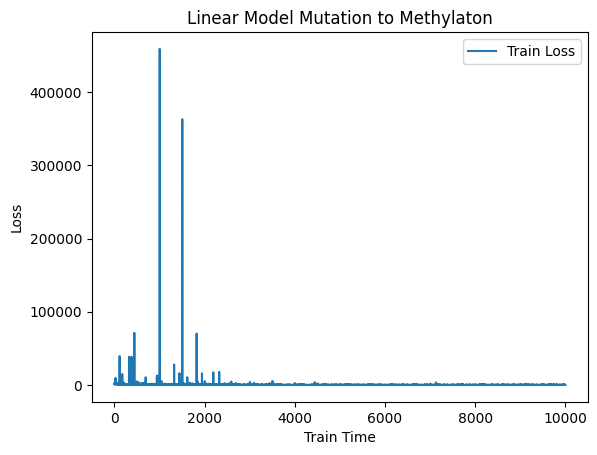

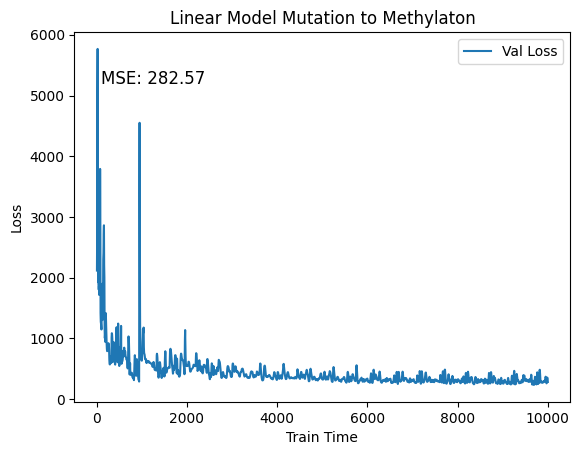

In [27]:
plt.plot(np.arange(len(train_losses)), train_losses, label='Train Loss')
plt.title("Linear Model Mutation to Methylaton")
plt.xlabel('Train Time')
plt.ylabel('Loss')
plt.legend()
plt.show()

x, val_loss = zip(*val_losses)
plt.plot(x, val_loss, label='Val Loss')
plt.title("Linear Model Mutation to Methylaton")
x_text = (len(x))  * 0.05
y_text = max(val_loss) * 0.9
plt.text(
    x_text,
    y_text,
    f"MSE: {last_val_loss.item():.2f}",
    fontsize=12,
)
plt.xlabel('Train Time')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
model_scripted = torch.jit.script(model)  # Export to TorchScript
if USE_ALL_SAMPLES:
    model_scripted.save("linear_model_script_mut.all_samples.pt")
else:
    model_scripted.save("linear_model_script_mut.pt")

In [29]:
linear_model = torch.jit.load("linear_model_script_mut.pt")

In [30]:
linear_model.state_dict()

OrderedDict([('0.weight',
              tensor([[-1.6108e-01,  2.7336e-02, -1.2865e-01,  ..., -2.9686e-02,
                       -2.7891e-01, -1.8784e-01],
                      [-1.9274e-01, -6.3959e-03, -1.2955e-01,  ..., -8.1124e-02,
                       -2.8462e-01, -1.9463e-01],
                      [ 4.8245e-03,  3.3895e-03,  4.6389e-04,  ..., -9.2467e-04,
                        1.2546e-03, -3.3559e-03],
                      ...,
                      [-1.4647e-01, -6.2676e-02, -1.3164e-01,  ..., -8.4705e-02,
                       -2.7055e-01, -6.5762e-02],
                      [-1.1287e-01, -1.6679e-02, -1.2389e-01,  ..., -4.8887e-02,
                       -1.2548e-01, -1.9196e-01],
                      [-3.6409e-01, -3.3060e-01, -6.6905e-01,  ..., -1.6668e-01,
                        6.0009e-01, -1.8654e-01]])),
             ('0.bias',
              tensor([-0.6579, -0.6667, -0.0615, -0.6487, -0.9289, -0.0583, -0.5299, -0.0554,
                      -0.5622,  0.2689, 

In [31]:
import numpy as np
from scipy.stats import spearmanr, pearsonr, kendalltau
import random
ones = [i for i in range(100)]
ones_2 = [i for i in range(100)]
random.shuffle(ones_2)
pearsonr(ones, ones_2)

PearsonRResult(statistic=0.03108310831083107, pvalue=0.7588453841945059)

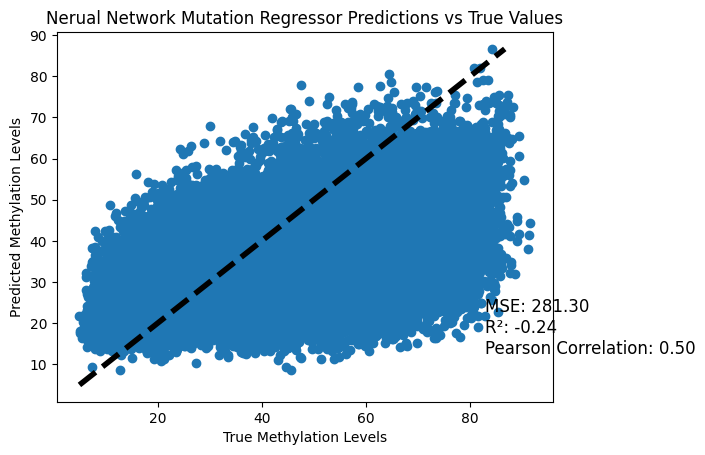

In [32]:
from sklearn.metrics import mean_squared_error, r2_score

actual = []
predicted = []
linear_model.eval()
with torch.no_grad():
    for expression, methylation in valloader:

        expression, methylation = expression.to(device), methylation.to(device)
        pred = linear_model(expression)
        actual.extend(methylation.cpu().numpy().flatten().tolist())
        predicted.extend(pred.cpu().numpy().flatten().tolist())


pearson_corr, _ = pearsonr(actual, predicted)
mse = mean_squared_error(actual, predicted)
r2 = r2_score(actual, predicted)

# Plot the Results
plt.scatter(actual, predicted)
plt.xlabel("True Methylation Levels")
plt.ylabel("Predicted Methylation Levels")
plt.title("Nerual Network Mutation Regressor Predictions vs True Values")
plt.plot(
    [min(actual), max(predicted)],
    [min(actual), max(predicted)],
    "k--",
    lw=4,
)

x_text = min(actual) + (max(actual) - min(actual)) * 0.9
y_text = min(predicted) + (max(predicted) - min(predicted)) * 0.05

plt.text(
    x_text,
    y_text,
    f"MSE: {mse:.2f}\nR²: {r2:.2f}\nPearson Correlation: {pearson_corr:.2f}",
    fontsize=12,
)

plt.show()